In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import to_categorical
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

[]


Using TensorFlow backend.


In [2]:
(xtrain,ytrain),(xvalid,yvalid)=cifar10.load_data()

170500096/170498071 [==============================] - 46s 0us/step


In [3]:
xtrain1=xtrain.astype(np.float32)/255
xvalid1=xvalid.astype(np.float32)/255
ytrain1=to_categorical(ytrain,10)
yvalid1=to_categorical(yvalid,10)

In [4]:
imgshape=xtrain1.shape[1:]
Ntrain=len(xtrain1)
Nvalid=len(xvalid1)

In [5]:
x=tf.placeholder(tf.float32,shape=[None,32,32,3])
y=tf.placeholder(tf.float32,shape=[None,10])

In [6]:
w1=tf.Variable(tf.random_normal(shape=[4,4,3,16],stddev=0.1))
b1=tf.Variable(tf.random_normal(shape=[16,],stddev=0.1))
w2=tf.Variable(tf.random_normal(shape=[4,4,16,32],stddev=0.1))
b2=tf.Variable(tf.random_normal(shape=[32,],stddev=0.1))
w3=tf.Variable(tf.random_normal(shape=[4,4,32,64],stddev=0.1))
b3=tf.Variable(tf.random_normal(shape=[64,],stddev=0.1))
w4=tf.Variable(tf.random_normal(shape=[1024,10],stddev=0.1))
b4=tf.Variable(tf.random_normal(shape=[10,],stddev=0.1))
kp1=tf.placeholder(tf.float32)
kp2=tf.placeholder(tf.float32)
kp3=tf.placeholder(tf.float32)
#kp4=tf.placeholder(tf.float32)

In [7]:
layer_cn1=tf.nn.conv2d(x,w1,strides=[1,1,1,1],padding='SAME')+b1
layer_cn1=tf.nn.leaky_relu(tf.layers.batch_normalization(layer_cn1,training=True))
layer_pool1=tf.nn.max_pool(layer_cn1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
layer_drop1=tf.nn.dropout(layer_pool1,keep_prob=kp1)

In [8]:
layer_cn2=tf.nn.leaky_relu(tf.layers.batch_normalization(tf.nn.conv2d(layer_drop1,w2,strides=[1,1,1,1],padding='SAME')+b2,training=True))
layer_pool2=tf.nn.max_pool(layer_cn2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
layer_drop2=tf.nn.dropout(layer_pool2,keep_prob=kp2)

In [9]:
layer_cn3=tf.nn.leaky_relu(tf.layers.batch_normalization(tf.nn.conv2d(layer_drop2,w3,strides=[1,1,1,1],padding='SAME')+b3,training=True))
layer_pool3=tf.nn.max_pool(layer_cn3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
layer_drop3=tf.nn.dropout(layer_pool3,keep_prob=kp3)

In [10]:
layer_reshp=tf.reshape(layer_pool3,shape=[-1,4*4*64])


In [11]:
layer_fc1=tf.matmul(layer_reshp,w4)+b4

In [12]:
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc1,labels=y))

In [13]:
optimize=tf.train.AdamOptimizer(0.01).minimize(cross_entropy)

In [14]:
prediction=tf.argmax(tf.nn.softmax(layer_fc1),axis=1)
accuracy=tf.reduce_mean(tf.cast(tf.equal(prediction,tf.argmax(y,axis=1)),tf.float32))*100

In [15]:
batchsize=100
epochs=4000

In [16]:
init=tf.global_variables_initializer()

In [17]:
train_loss=[]
valid_loss=[]
train_acc=[]
valid_acc=[]
with tf.Session() as s:
    s.run(init)
    for i in range(epochs):
        index=np.random.choice(Ntrain,batchsize,replace=False)
        batch_x=xtrain1[index]
        batch_y=ytrain1[index]
        feeddict={x:batch_x,y:batch_y,kp1:1.0,kp2:1.0,kp3:0.8}
        batch_loss,_,batchacc=s.run([cross_entropy,optimize,accuracy],feed_dict=feeddict)
        if (i%10)==0:
            
            # Computing Train accuracy and loss
            index1=np.random.choice(Ntrain,10000,replace=False)
            batch_train_x=xtrain1[index1]
            batch_train_y=ytrain1[index1]
            feeddict1={x:batch_train_x,y:batch_train_y,kp1:1.0,kp2:1.0,kp3:1.0}
            trainloss,trainacc=s.run([cross_entropy,accuracy],feed_dict=feeddict1)
            train_loss.append(trainloss)
            train_acc.append(trainacc)
            
            #Computing validation Accuracy and loss
            
            batch_valid_x=xvalid1
            batch_valid_y=yvalid1
            feeddict2={x:batch_valid_x,y:batch_valid_y,kp1:1.0,kp2:1.0,kp3:1.0}
            validloss,validacc=s.run([cross_entropy,accuracy],feed_dict=feeddict2)
            valid_loss.append(validloss)
            valid_acc.append(validacc)
            
            if i%100==0:
                print('epoch:',i,' trainloss:',trainloss,' trainaccuracy:',trainacc,'validloss:',validloss,'validacc:',validacc)

epoch: 0  trainloss: 9.726503  trainaccuracy: 13.65 validloss: 9.727881 validacc: 13.160001
epoch: 100  trainloss: 1.7165297  trainaccuracy: 38.05 validloss: 1.7210981 validacc: 37.63
epoch: 200  trainloss: 1.4501479  trainaccuracy: 47.15 validloss: 1.4689955 validacc: 47.08
epoch: 300  trainloss: 1.373252  trainaccuracy: 52.07 validloss: 1.4012108 validacc: 50.480003
epoch: 400  trainloss: 1.2410346  trainaccuracy: 55.79 validloss: 1.2650895 validacc: 54.85
epoch: 500  trainloss: 1.0910106  trainaccuracy: 61.83 validloss: 1.1586404 validacc: 59.02
epoch: 600  trainloss: 1.0546582  trainaccuracy: 62.730003 validloss: 1.1119547 validacc: 61.08
epoch: 700  trainloss: 0.96525764  trainaccuracy: 66.22 validloss: 1.0358961 validacc: 64.090004
epoch: 800  trainloss: 0.94763184  trainaccuracy: 66.46 validloss: 1.0407959 validacc: 63.14
epoch: 900  trainloss: 0.90223515  trainaccuracy: 69.16 validloss: 0.9934821 validacc: 65.57
epoch: 1000  trainloss: 0.89865685  trainaccuracy: 69.53 validloss

In [18]:
#During Analysis if weights in model are limited less and we are using dropout then it is going to hurt model accuracy instead of
#improving it
# it is better to apply dropout to layer with large number of weights as that layer has more tendency to overfit
#during prediction and val acc, train acc calculations we shouldnt apply dropout to model so we set keep prob to all layers as 1
# Clearly Dropout and BatchNormalization CNN performs better than Normal deep CNN in terms of accuracy and loss

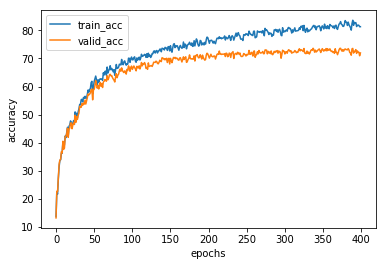

In [19]:
plt.plot(train_acc,label='train_acc')
plt.plot(valid_acc,label='valid_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

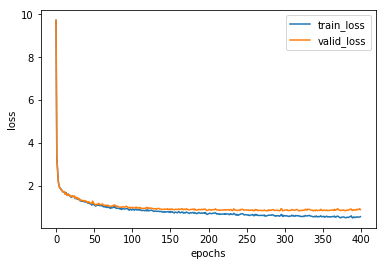

In [20]:
plt.plot(train_loss,label='train_loss')
plt.plot(valid_loss,label='valid_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()